# Learners or practicioner?

> Q: For the data in the given category, did it come from the expert variant subreddit or the learn variant?

In [65]:
import pandas as pd
import numpy as np
import scipy

import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



In [2]:
df = pd.read_csv('../data/csv/combined_subreddits_processed.csv')

In [3]:
text_feats = ['title', 'selftext', 'subreddit']
num_and_bool_feats = [col for col in df.columns if col not in text_feats]
df[num_and_bool_feats] = df[num_and_bool_feats].copy().astype(float)

df.head()

,title,num_comments,score,subreddit,created_utc,is_self,selftext,title_len,title_len_log1p
0,How to find a math REU for this summer,44.0,66.0,math,1.483229e+09,1.0,"If you, or someone you love, is an undergradua...",38.0,3.663562
1,"Found this weird typo in a book I was reading,...",0.0,0.0,math,1.483230e+09,0.0,[deleted],70.0,4.262680
2,2017 is a prime number.,4.0,0.0,math,1.483233e+09,1.0,[removed],23.0,3.178054
3,Injective functions,2.0,0.0,math,1.483248e+09,1.0,[removed],19.0,2.995732
4,Want to go into a major requiring Calculus but...,1.0,1.0,math,1.483251e+09,1.0,[removed],202.0,5.313206


We're doing three separate classification models right now, so we'll split our data, with a target vector taking value `True` if the observation is from the `learn` class and False otherwise.

In [4]:
X = df.drop(['subreddit'],1)
y = df['subreddit'].str.lower()

y_math = y[y.str.contains('math')]
y_math = y_math.str.contains('learn')

y_python = y[y.str.contains('python')]
y_python = y_python.str.contains('learn')

y_datascience = y[y.str.contains('datascience') | y.str.contains('learnmachinelearning')]
y_datascience = y_datascience.str.contains('learn')


X_math = X.loc[y_math.index, :]
X_python = X.loc[y_python.index, :]
X_datascience = X.loc[y_datascience.index, :]


In [5]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_math, y_math, random_state=41)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_datascience, y_datascience, random_state=41)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_python, y_python, random_state=41)

## Encoding Text as Numerical Features

Unlike when we were predicting whether or not a particular post beats the median score, we were keeping track of the subreddit for each post. The net effect in processing the data here just means that we have no more categorical features to encode as dummy variables. 


I want going to want to use a _text frequency-inverse document frequency_ (tf-idf) tokenizer on the `title` and `self-text` features, but to do this with a pipeline object from SKLearn, we can define a custom transformer that will only affect the `title` and `selftext`. This is not built in complete generality, so I make no promise that it will work without modification to a different data structure (i.e. if you're using different matrix encodings). 

In [6]:
from sklearn.base import TransformerMixin, BaseEstimator

class Tfidf_Col(TransformerMixin, BaseEstimator):
    def __init__(self, cols=[]):
        self.cols = cols
        self.vects = {col:TfidfVectorizer() for col in cols}
        
    def transform(self, X, *_):
        X = X.copy()
        transformed = []
        for col in self.cols:
            tmp = self.vects[col].transform(X.loc[:,col])
            transformed.append(tmp)
            X.drop(col, 1, inplace=True)
            
        X = scipy.sparse.csr_matrix(X.values)
        transformed.append(X)
        X = scipy.sparse.hstack(transformed)
        return X
        
    def fit(self, X, *_):
        for col in self.cols:
            self.vects[col].fit(X.loc[:,col])
        return self

## Base Model

In classifying models, we can compare them to a baseline model. For this we will use the most basic classification model: assume everything is the most common class. For our three classes this means the following:

|class| most common type in train data| baseline accuracy on test data|
|-|
|`datascience`| `datascience`| 67.19%|
|`math`| `math`| 53.58% | 
|`python`| `learnpython`| 61.80%| 

In [7]:
y_train_d.mean(), y_train_m.mean(), y_train_p.mean()

(0.33132691278758697, 0.4667558040598031, 0.6114180478821363)

In [8]:
y_test_d.mean(), y_test_m.mean(), y_test_p.mean()

(0.3281187324508624, 0.46420323325635104, 0.6180227874323858)

## K-Nearest Neighbors

In [9]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier()),
]

np.random.seed(41)

my_params = {
    'knn__n_neighbors':range(5,10),
}

pipe = Pipeline(pl)
knn_d = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

knn_d.fit(X_train_d, y_train_d)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': range(5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Text(0.5,0,'number of neighbors')

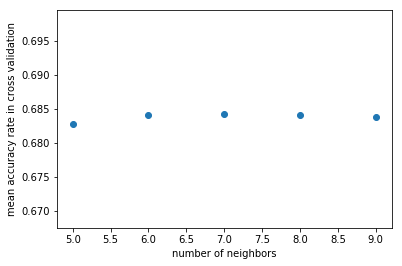

In [10]:
x = []
y = []
for index, score in enumerate(knn_d.cv_results_['mean_test_score']):
    n_neighbors = knn_d.cv_results_['params'][index]['knn__n_neighbors']
    x.append(n_neighbors)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('number of neighbors')

In [11]:
knn_d.best_params_

{'knn__n_neighbors': 7}

In [12]:
knn_d.score(X_train_d, y_train_d), knn_d.score(X_test_d, y_test_d)

(0.693151417870519, 0.6891295627757722)

In [13]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier()),
]

np.random.seed(41)

my_params = {
    'knn__n_neighbors':range(5,10),
}

pipe = Pipeline(pl)
knn_m = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

knn_m.fit(X_train_m, y_train_m)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': range(5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Text(0.5,0,'number of neighbors')

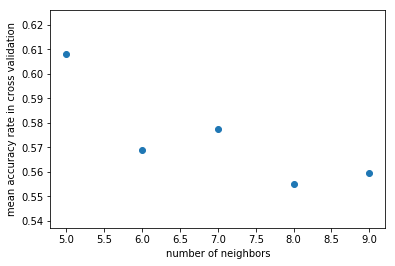

In [14]:
x = []
y = []
for index, score in enumerate(knn_m.cv_results_['mean_test_score']):
    n_neighbors = knn_m.cv_results_['params'][index]['knn__n_neighbors']
    x.append(n_neighbors)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('number of neighbors')

In [15]:
knn_m.best_params_

{'knn__n_neighbors': 5}

In [16]:
knn_m.score(X_train_m, y_train_m), knn_m.score(X_test_m, y_test_m)

(0.8441311130019044, 0.6397228637413395)

In [17]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier()),
]

np.random.seed(41)

my_params = {
    'knn__n_neighbors':range(5,10),
}

pipe = Pipeline(pl)
knn_p = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

knn_p.fit(X_train_p, y_train_p)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': range(5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Text(0.5,0,'number of neighbors')

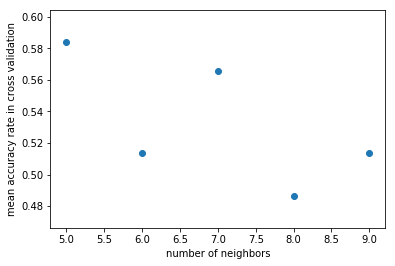

In [18]:
x = []
y = []
for index, score in enumerate(knn_p.cv_results_['mean_test_score']):
    n_neighbors = knn_p.cv_results_['params'][index]['knn__n_neighbors']
    x.append(n_neighbors)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('number of neighbors')

In [19]:
knn_p.best_params_

{'knn__n_neighbors': 5}

In [20]:
knn_p.score(X_train_p, y_train_p), knn_p.score(X_test_p, y_test_p)

(0.7464702271332105, 0.5817700540913799)

So this result is interesting. On the one hand it's barely better than the baseline predictor (sometimes it's worse), but the behavior of the model with relation to the number of neighbors seems to be very different for the different categories. If there was great interest in this more compute time could be spent on these models, but since they're slow to tune and run (a disadvantage to the KNN models in deployment as well) we'll look at that in a future project. 

|class| Baseline Accuracy| K-Nearest Neighbors Accuracy
|-|
|`datascience`| 67.19%| 68.91%
|`math`| 53.58% | 63.97%
|`python`| 61.80%| 58.%18

## Decision Tree

In [21]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('dt', DecisionTreeClassifier()),
]

np.random.seed(41)

my_params = {
    'dt__max_depth':range(2,20),
}

pipe = Pipeline(pl)
dt_d = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

dt_d.fit(X_train_d, y_train_d)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
    ...     min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'dt__max_depth': range(2, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

Text(0.5,0,'max depth of tree')

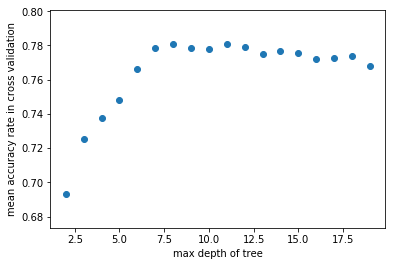

In [28]:
x = []
y = []
for index, score in enumerate(dt_d.cv_results_['mean_test_score']):
    depth = dt_d.cv_results_['params'][index]['dt__max_depth']
    x.append(depth)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('max depth of tree')

In [29]:
dt_d.best_params_

{'dt__max_depth': 8}

In [30]:
dt_d.score(X_train_d, y_train_d), dt_d.score(X_test_d, y_test_d)

(0.8259764579989299, 0.7934215804251905)

In [31]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('dt', DecisionTreeClassifier()),
]

np.random.seed(41)

my_params = {
    'dt__max_depth':range(2,20),
}

pipe = Pipeline(pl)
dt_m = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

dt_m.fit(X_train_m, y_train_m)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
    ...     min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'dt__max_depth': range(2, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

Text(0.5,0,'max depth of tree')

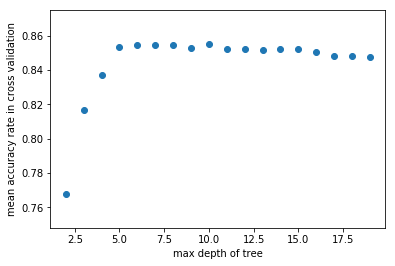

In [32]:
x = []
y = []
for index, score in enumerate(dt_m.cv_results_['mean_test_score']):
    depth = dt_m.cv_results_['params'][index]['dt__max_depth']
    x.append(depth)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('max depth of tree')

In [33]:
dt_m.best_params_

{'dt__max_depth': 10}

In [34]:
dt_m.score(X_train_m, y_train_m), dt_m.score(X_test_m, y_test_m)

(0.8974514808962359, 0.8634982375106357)

In [42]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('dt', DecisionTreeClassifier()),
]

np.random.seed(41)

my_params = {
    'dt__max_depth':range(2,20),
}

pipe = Pipeline(pl)
dt_p = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

dt_p.fit(X_train_p, y_train_p)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
    ...     min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'dt__max_depth': range(2, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

Text(0.5,0,'max depth of tree')

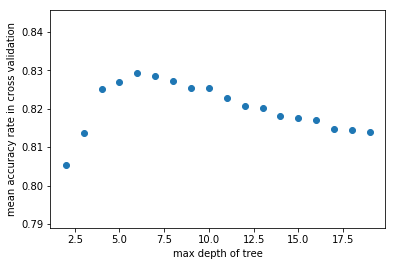

In [43]:
x = []
y = []
for index, score in enumerate(dt_p.cv_results_['mean_test_score']):
    depth = dt_p.cv_results_['params'][index]['dt__max_depth']
    x.append(depth)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('max depth of tree')

In [44]:
dt_p.best_params_

{'dt__max_depth': 6}

In [45]:
dt_p.score(X_train_p, y_train_p), dt_p.score(X_test_p, y_test_p)

(0.8349447513812155, 0.8307054896996202)

|class| Baseline Accuracy| Decision Tree Accuracy
|-|
|`datascience`| 67.19%| 79.34%
|`math`| 53.58% | 86.35%
|`python`| 61.80%| 83.07%



These decision trees are looking very good so far, similar test and training accuracy scores so no obvious evidence of over fitting. And of course our accuracy scores are beating our baseline.

## Random Forest

In [46]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier()),
]

np.random.seed(41)

my_params = {
    'rf__n_estimators':range(7,14),
}

pipe = Pipeline(pl)
rf_d = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

rf_d.fit(X_train_d, y_train_d)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurit...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': range(7, 14)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Text(0.5,0,'number of trees')

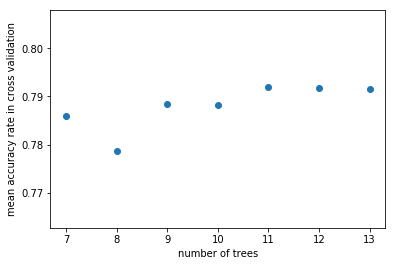

In [49]:
x = []
y = []
for index, score in enumerate(rf_d.cv_results_['mean_test_score']):
    depth = rf_d.cv_results_['params'][index]['rf__n_estimators']
    x.append(depth)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('number of trees')

In [50]:
rf_d.best_params_

{'rf__n_estimators': 11}

In [51]:
rf_d.score(X_train_d, y_train_d), rf_d.score(X_test_d, y_test_d)

(0.9907704654895666, 0.7962294424388288)

In [52]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier()),
]

np.random.seed(41)

my_params = {
    'rf__n_estimators':range(6,14),
}

pipe = Pipeline(pl)
rf_m = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

rf_m.fit(X_train_m, y_train_m)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurit...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': range(6, 14)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Text(0.5,0,'number of trees')

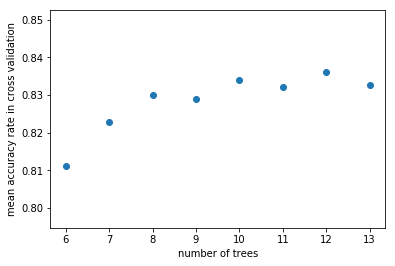

In [54]:
x = []
y = []
for index, score in enumerate(rf_m.cv_results_['mean_test_score']):
    depth = rf_m.cv_results_['params'][index]['rf__n_estimators']
    x.append(depth)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('number of trees')

In [55]:
rf_d.best_params_

{'rf__n_estimators': 11}

In [56]:
rf_m.score(X_train_m, y_train_m), rf_m.score(X_test_m, y_test_m)

(0.9945707224180543, 0.8371216725416312)

In [61]:
pl = [
    ('tfidf', Tfidf_Col(['title', 'selftext'])),
    ('ss', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier()),
]

np.random.seed(41)

my_params = {
    'rf__n_estimators':range(6,14),
}

pipe = Pipeline(pl)
rf_p = GridSearchCV(pipe, param_grid=my_params, return_train_score=True)

rf_p.fit(X_train_p, y_train_p)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', Tfidf_Col(cols=['title', 'selftext'])), ('ss', StandardScaler(copy=True, with_mean=False, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurit...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': range(6, 14)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Text(0.5,0,'number of trees')

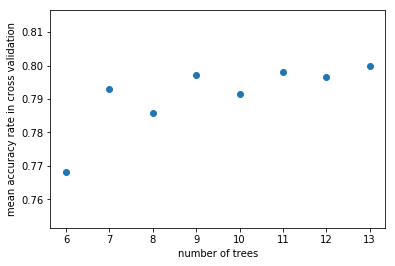

In [62]:
x = []
y = []
for index, score in enumerate(rf_p.cv_results_['mean_test_score']):
    depth = rf_p.cv_results_['params'][index]['rf__n_estimators']
    x.append(depth)
    y.append(score)
plt.scatter(x,y)
plt.ylabel('mean accuracy rate in cross validation')
plt.xlabel('number of trees')

In [63]:
rf_p.best_params_

{'rf__n_estimators': 13}

In [64]:
rf_p.score(X_train_p, y_train_p), rf_p.score(X_test_p, y_test_p)

(0.9927486187845304, 0.7984808378409484)

|class| Baseline Accuracy| Random Forest Accuracy
|-|
|`datascience`| 67.19%| 79.62%
|`math`| 53.58% | 83.71%
|`python`| 61.80%| 79.85%

## Summary

|class| Baseline Accuracy| K-Nearest Neighbors Accuracy | Decision Tree Accuracy | Random Forest Accuracy
|-|
|`datascience`| 67.19%| 68.91% | 79.34% | 79.62%
|`math`| 53.58% | 63.97% | 86.35% | 83.71%
|`python`| 61.80%| 58.18% | 83.07% | 79.85%

On the collected data, the Decision Tree model is the best at telling the difference between posts from a subreddit about a topic and posts from a subreddit about learning that topic. This is very convenient as it's is also the fastest to use in deployment. 

In [68]:
for model_name, model in {
    'knn_d':knn_d, 'knn_m':knn_m, 'knn_p':knn_p, 
    'dt_d':dt_d, 'dt_m':dt_m, 'dt_p':dt_p, 
    'rf_d':rf_d, 'rf_m':rf_m, 'rf_p':rf_p
}.items():
    with open(f'../models/{model_name}.pkl', 'wb') as file:
        pickle.dump(model, file)    